# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Group Project by Dolphin Sharma and Charles Crocicchia

## Data Modeling

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Directories for data and plots
data_paths = {
    'ridge': '../data/processed_data/linear_regression_data.csv',
    'decision_tree': '../data/processed_data/decision_tree_data.csv',
    'random_forest': '../data/processed_data/random_forest_data.csv'
}

plots_directory = '../plots/'

In [4]:
# Features and targets
features = [
    'Corn_Acres_Planted', 'Soybean_Acres_Planted', 'Corn_Cash_Receipts',
    'Corn_Production_Bushels', 'Corn_Production_Dollars', 'Corn_Yield_Bushels',
    'Soybean_Cash_Receipts', 'Soybean_Production_Bushels', 'Soybean_Production_Dollars',
    'Soybean_Yield_Bushels'
]

targets = ['Employment_Rural', 'Personal_Income_Rural', 'Poverty_Levels']

In [5]:
# Load data
def load_data(path):
    return pd.read_csv(path)

In [6]:
# Prepare data
def prepare_data(data, target):
    data_cleaned = data.dropna(subset=features + [target])
    X = data_cleaned[features]
    y = data_cleaned[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [7]:
# Train and evaluate model
def train_and_evaluate_model(model, param_grid, X_train, X_test, y_train, y_test, target_name):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Cross-validation RMSE
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_cv_rmse = np.sqrt(-cv_scores.mean())

    # Test set predictions
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Print evaluation metrics
    print(f"\nTarget: {target_name}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Mean CV RMSE: {mean_cv_rmse:.2f}")
    print(f"R² Score on Test Set: {r2:.2f}")
    print(f"RMSE on Test Set: {rmse:.2f}\n")
    
    return {
        'Best Parameters': grid_search.best_params_,
        'R2': r2,
        'RMSE': rmse,
        'CV_RMSE': mean_cv_rmse,
        'y_test': y_test,
        'y_pred': y_pred
    }

In [8]:
# Plot evaluation metrics (R², RMSE, and Mean CV RMSE)
def plot_evaluation_metrics(results, model_name, plot_dir=plots_directory):
    targets_labels = ['Employment', 'Personal Income', 'Poverty Level']
    r2_scores = [results[t]['R2'] for t in targets]
    rmse_scores = [results[t]['RMSE'] for t in targets]
    cv_rmse_scores = [results[t]['CV_RMSE'] for t in targets]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot R² scores
    bars1 = ax1.bar(targets_labels, r2_scores, color='tab:olive')
    ax1.set_title('R² Score for Each Target', fontweight='bold')
    ax1.set_xlabel('Target Variable', fontstyle='italic')
    ax1.set_ylabel('R² Score', fontstyle='italic')
    for bar in bars1:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

    # Plot RMSE scores
    bars2 = ax2.bar(targets_labels, rmse_scores, color='#f1c232')
    ax2.set_title('RMSE for Each Target', fontweight='bold')
    ax2.set_xlabel('Target Variable', fontstyle='italic')
    ax2.set_ylabel('RMSE', fontstyle='italic')
    for bar in bars2:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

    # Plot Mean CV RMSE scores
    bars3 = ax3.bar(targets_labels, cv_rmse_scores, color='#0D98BA')
    ax3.set_title('Mean CV RMSE for Each Target', fontweight='bold')
    ax3.set_xlabel('Target Variable', fontstyle='italic')
    ax3.set_ylabel('Mean CV RMSE', fontstyle='italic')
    for bar in bars3:
        yval = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

    plt.tight_layout()
    plot_path = os.path.join(plot_dir, f'{model_name}_results.png')
    plt.savefig(plot_path)
    plt.show()

In [9]:
# Plot actual vs predicted for each target variable in a single figure with subplots
def plot_actual_vs_predicted(y_test_data, y_pred_data, plot_dir=plots_directory):
    targets = ['Employment', 'Personal Income', 'Poverty Level']
    colors = ['#2986cc', '#8fce00', '#6a329f']
    ideal_line_color = '#999999'

    # Create subplots for the three targets
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    
    for i, (target, y_test, y_pred, color) in enumerate(zip(targets, y_test_data, y_pred_data, colors)):
        # Scatter plot of Actual vs Predicted values
        axes[i].scatter(y_test, y_test, color=color, label='Actual')
        axes[i].scatter(y_test, y_pred, color='#ff7f0e', label='Predicted')
        # Ideal line (diagonal)
        axes[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color=ideal_line_color, label='Ideal Line')
        
        # Title and labels
        axes[i].set_title(f'{target}: Actual vs Predicted', fontweight='bold')
        axes[i].set_xlabel(f'Actual {target}', fontstyle='italic')
        axes[i].set_ylabel(f'Predicted {target}', fontstyle='italic')
        
        # Specific formatting for larger numbers
        if target in targets:
            axes[i].get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            axes[i].get_xaxis().set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
        # Rotate x-axis labels
        axes[i].tick_params(axis='x', rotation=45)
        
        # Legend
        axes[i].legend()
    
    # Adjust layout for cleaner appearance
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'actual_vs_predicted.png'))
    plt.show()


Target: Employment_Rural
Best Parameters: {'alpha': 0.1}
Mean CV RMSE: 0.06
R² Score on Test Set: 1.00
RMSE on Test Set: 0.04


Target: Personal_Income_Rural
Best Parameters: {'alpha': 1.0}
Mean CV RMSE: 189675.13
R² Score on Test Set: 0.98
RMSE on Test Set: 82328.87


Target: Poverty_Levels
Best Parameters: {'alpha': 1.0}
Mean CV RMSE: 188802.58
R² Score on Test Set: 0.94
RMSE on Test Set: 134929.54


Target: Employment_Rural
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean CV RMSE: 403710.48
R² Score on Test Set: 0.91
RMSE on Test Set: 167507.13


Target: Personal_Income_Rural
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean CV RMSE: 408630.48
R² Score on Test Set: 0.89
RMSE on Test Set: 197457.28


Target: Poverty_Levels
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean CV RMSE: 513454.16
R² Score on Test 

C:\Users\deeps\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Target: Personal_Income_Rural
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean CV RMSE: 341713.84
R² Score on Test Set: 0.97
RMSE on Test Set: 110522.78


Target: Poverty_Levels
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean CV RMSE: 430534.24
R² Score on Test Set: 0.94
RMSE on Test Set: 139691.87



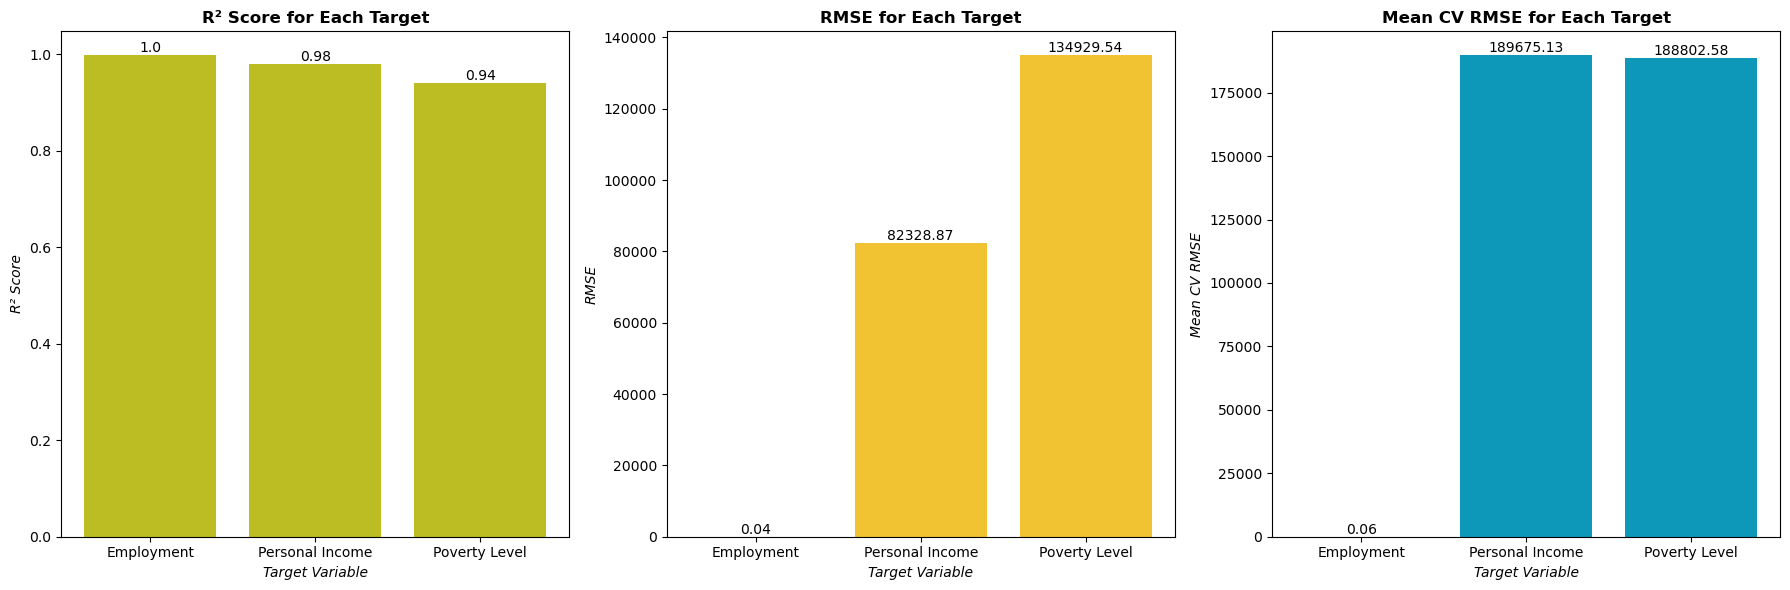

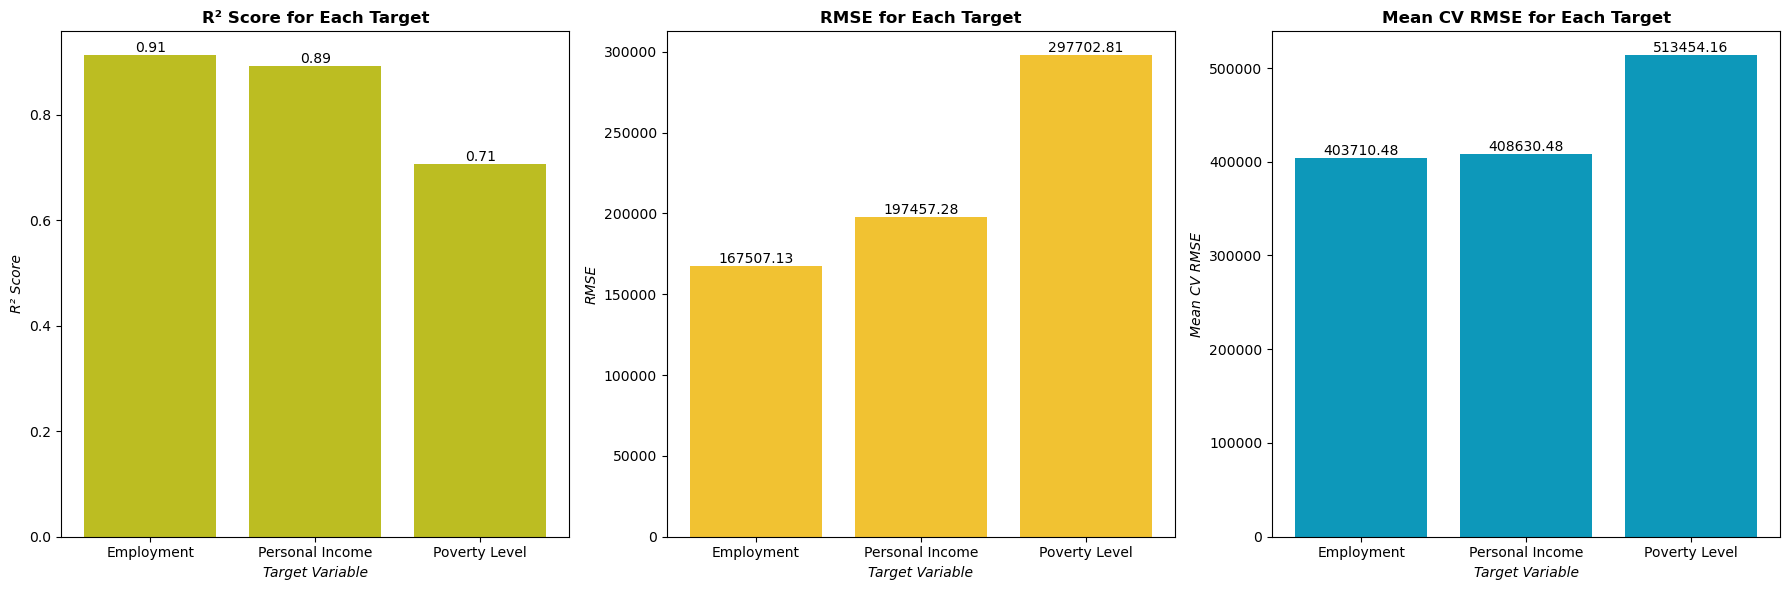

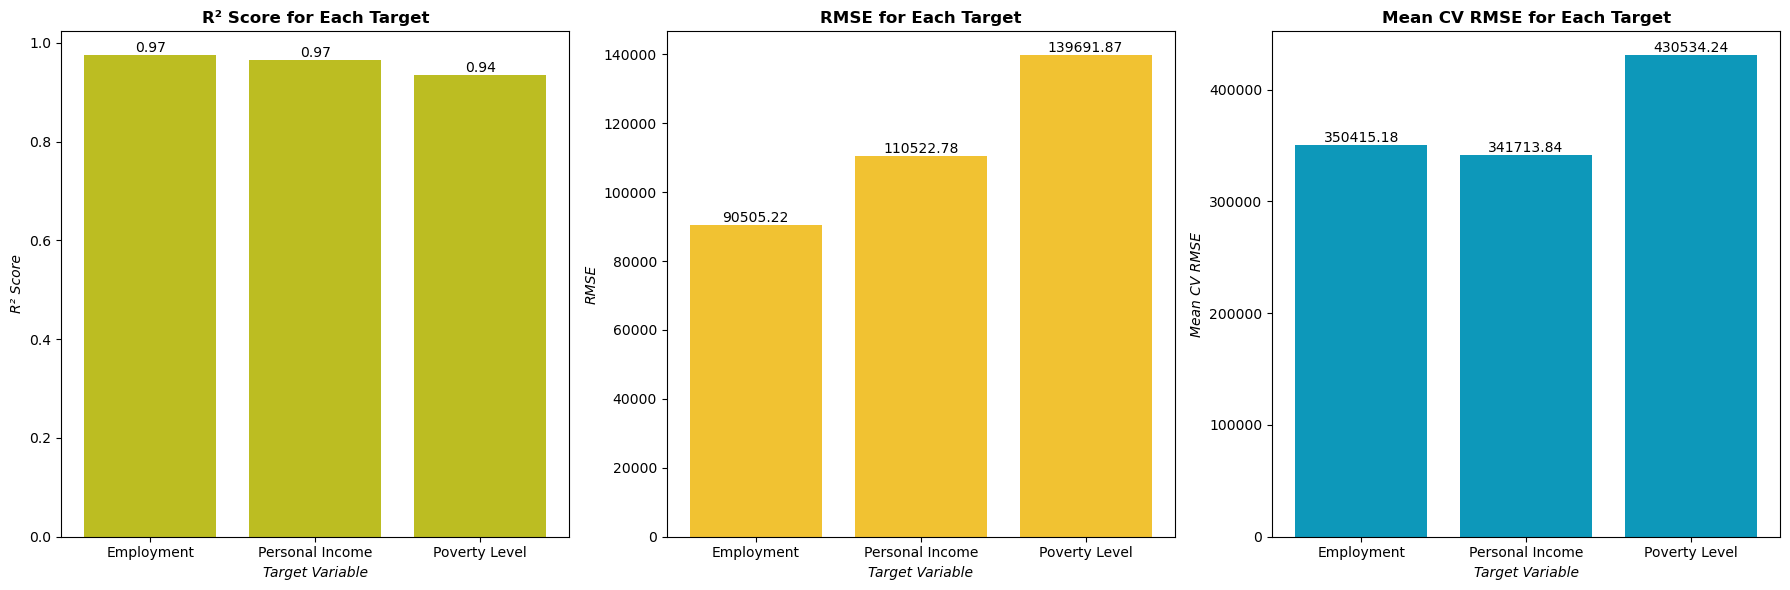

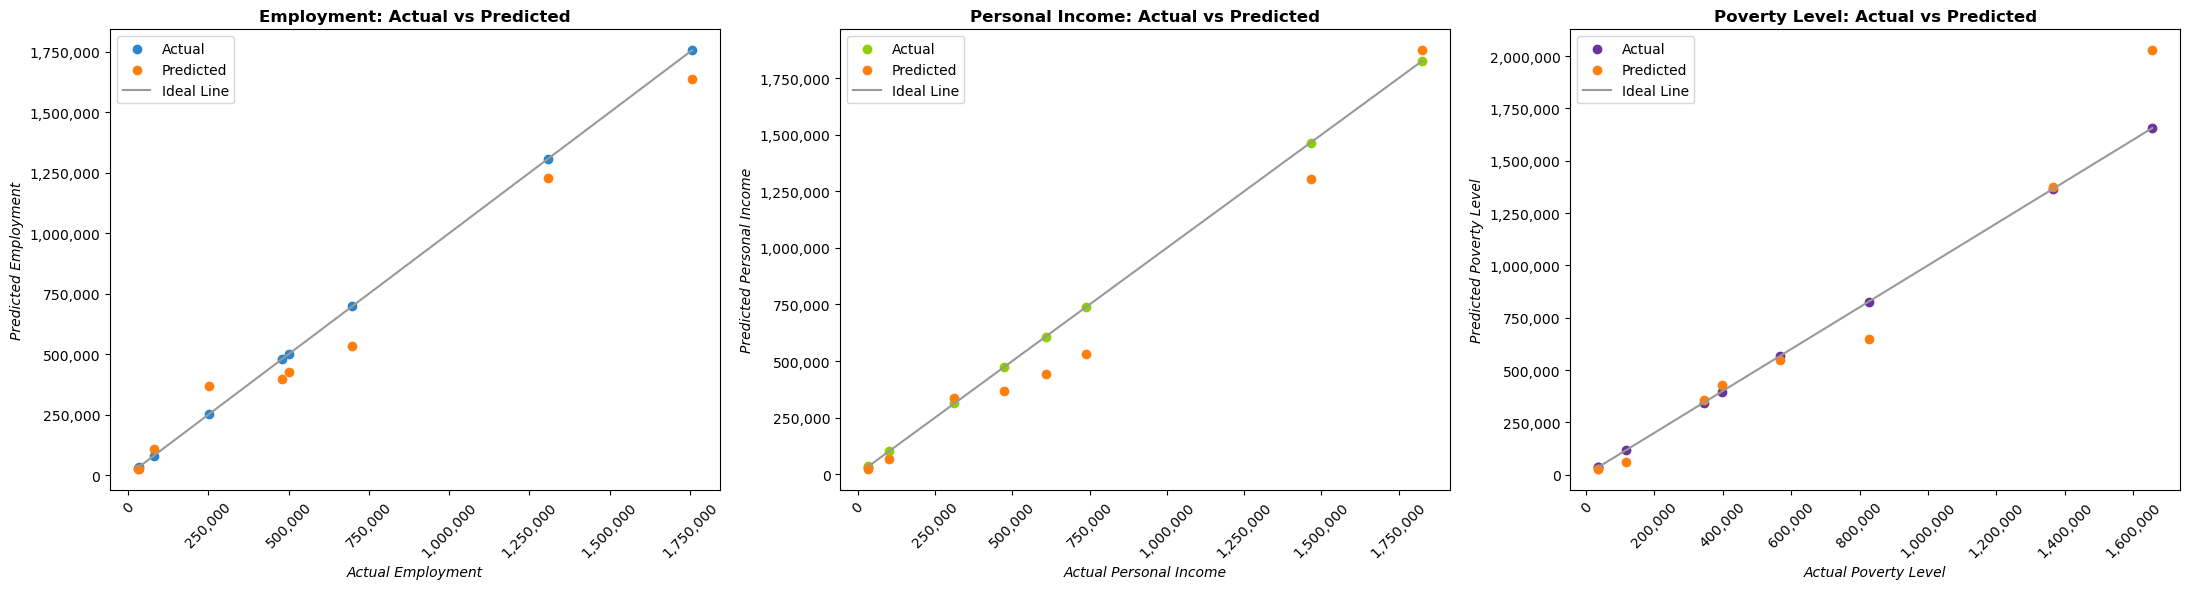

In [10]:
# Define models and parameters
models = {
    'ridge': (Ridge(), {'alpha': [0.1, 1.0, 10.0, 100.0]}),
    'decision_tree': (DecisionTreeRegressor(random_state=42), {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [None, 'sqrt', 'log2']
    }),
    'random_forest': (RandomForestRegressor(random_state=42), {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    })
}

# Run models and store results
results = {}
y_test_rf = []
y_pred_rf = []

# Step 1: Train and evaluate models in the specified order
for model_name, (model, param_grid) in models.items():
    data = load_data(data_paths[model_name])
    results[model_name] = {}
    
    for target in targets:
        X_train, X_test, y_train, y_test = prepare_data(data, target)
        results[model_name][target] = train_and_evaluate_model(model, param_grid, X_train, X_test, y_train, y_test, target)
        
        # Collect Random Forest results for actual vs predicted plot later
        if model_name == 'random_forest':
            y_test_rf.append(results[model_name][target]['y_test'])
            y_pred_rf.append(results[model_name][target]['y_pred'])

# Step 2: Plot evaluation metrics for each model after all models have been run
for model_name in models.keys():
    plot_evaluation_metrics(results[model_name], model_name)

# Step 3: Plot actual vs predicted for Random Forest only after evaluation metrics
plot_actual_vs_predicted(y_test_rf, y_pred_rf)

### Interpretation

#### Ridge Regression

1. **Target: Employment_Rural**

Test Set Performance:
* R² Score: 1.00, which is ideal and suggests the model explains nearly all variability in the target.
* RMSE: 0.04, aligning with the cross-validation results and indicating minimal error.
* Cross-Validation Scores (Negative MSE): These scores are close to zero, suggesting very low error across folds. The mean CV RMSE is also very low at 0.06, indicating that the model performs consistently across cross-validation splits with minimal error.

The model performs exceptionally well for Employment_Rural, with nearly perfect predictions. This suggests a strong linear relationship with the chosen features and minimal overfitting, as the cross-validation and test errors are similarly low.

2. **Target: Personal_Income_Rural**

Test Set Performance:
* R² Score: 0.98, indicating that the model explains 98% of the variability in Personal_Income_Rural, a strong fit but not perfect.
* RMSE: 82,328.87, which is lower than the cross-validation RMSE, suggesting the model might generalize better than expected based on the training data alone.
* Cross-Validation Scores (Negative MSE): These values are larger in magnitude, indicating more substantial prediction errors. They range from -3.5 billion to -89 billion, showing some variability across folds. The mean CV RMSE is high at 189,675.13, indicating that the model's errors are larger on average across different splits.

The model performs well in explaining Personal_Income_Rural but faces higher errors in cross-validation, potentially due to high variance in this target or some outliers. Despite this, the model generalizes well on the test set.

3. **Target: Poverty_Levels**

Test Set Performance:
* R² Score: 0.94, which is still strong, indicating that the model explains 94% of the variability in Poverty_Levels.
* RMSE: 134,929.54, higher than for Personal_Income_Rural, suggesting higher prediction errors for Poverty_Levels than for the other targets.
* Cross-Validation Scores (Negative MSE): These are also high, ranging from around -4 billion to -106 billion, showing a wide variability across folds. The mean CV RMSE is 188,802.58, suggesting relatively high errors in cross-validation.

The model provides a strong fit for Poverty_Levels, but the errors are relatively high, as shown by both cross-validation and test RMSE. This might suggest some data points or regions where the model struggles to generalize, potentially due to complexity or noise in this target variable.

**Summary**

The best parameter for Ridge regularization was alpha = 1.0 across targets, which balances model complexity with predictive accuracy. The model performed best for Employment_Rural, followed by Personal_Income_Rural and Poverty_Levels, with increasing error levels. Overall, these results indicate that the model explains a significant amount of variance for each target, though there is room for refinement, especially for Poverty_Levels.

#### Decision Tree

1. **Target: Employment_Rural**

Test Set Performance:
* R² Score: 0.91, indicating that the model explains 91% of the variance in Employment_Rural, a strong but imperfect fit.
* RMSE: 167,507.13, which is lower than the cross-validation RMSE, suggesting that the model may perform better on this specific test set than on the cross-validation splits.
* Cross-Validation Scores (Negative MSE): The scores are relatively large, ranging from -1.5 billion to around -346 billion. The high Mean CV RMSE of 403,710.48 suggests significant variation in prediction error across folds and generally higher error for this target.

The Decision Tree model has a reasonable fit for Employment_Rural, but the cross-validation error is relatively high, indicating that the model might have difficulty generalizing across different data subsets. The high RMSE suggests that the model may struggle with complexity or overfitting.

2. **Target: Personal_Income_Rural**

Test Set Performance:
* R² Score: 0.89, meaning the model explains 89% of the variance in Personal_Income_Rural, a relatively strong fit but not as high as the Linear Regression model.
* RMSE: 197,457.28, which is still substantial, highlighting that the model struggles to predict Personal_Income_Rural with low error.
* Cross-Validation Scores (Negative MSE): The cross-validation scores are again large, ranging from -2.2 billion to around -256 billion, with a Mean CV RMSE of 408,630.48, indicating substantial prediction error.

For Personal_Income_Rural, the Decision Tree model has a relatively good fit (R² of 0.89), but both cross-validation and test set RMSE scores suggest a high level of error. This could indicate that the model is capturing non-linear relationships but still lacks consistency and precision, possibly due to high data variability or overfitting on particular samples.

3. **Target: Poverty_Levels**

Test Set Performance:
* R² Score: 0.71, meaning the model explains 71% of the variance in Poverty_Levels. This R² is lower than for the other targets, indicating a weaker fit.
* RMSE: 297,702.81, which is very high, suggesting a considerable degree of error in predictions on the test set.
* Cross-Validation Scores (Negative MSE): These scores vary significantly, from around -9.4 billion to -675 billion, with the highest Mean CV RMSE of 513,454.16 among the three targets.

The Decision Tree model appears to struggle the most with Poverty_Levels, as evidenced by both the lower R² score and the high cross-validation and test RMSE values. This could indicate either high data complexity or that the target contains variability that the model is unable to capture effectively, likely due to overfitting on particular data patterns.

**Summary**

For the Decision Tree model, the best fit is seen with Employment_Rural and Personal_Income_Rural, though the error levels (RMSE) are higher than desired. For Poverty_Levels, both the R² and RMSE scores suggest that the model struggles to generalize effectively. The high cross-validation RMSE for all targets suggests that the model may have overfitting issues, or that there may be outliers or noise impacting its ability to make consistent predictions across different data splits.

#### Random Forest

1. **Target: Employment_Rural**

Test Set Performance:
* R² Score: 0.97, meaning the model explains 97% of the variance in Employment_Rural, showing a very strong fit.
* RMSE: 90,505.22, which is significantly lower than the cross-validation RMSE, suggesting good generalization to the test set.
* Cross-Validation Scores (Negative MSE): The scores range from -423 million to around -418 billion, with a Mean CV RMSE of 350,415.18. This indicates substantial variation across folds, though the error is generally lower compared to the Decision Tree model.

The Random Forest model performs very well for Employment_Rural, with a high R² and a relatively low test set RMSE. While cross-validation errors are higher, the model shows better consistency across different data subsets compared to Decision Tree, likely due to Random Forest’s ability to reduce overfitting.

2. **Target: Personal_Income_Rural**

Test Set Performance:
* R² Score: 0.97, indicating the model explains 97% of the variance in Personal_Income_Rural, a strong fit.
* RMSE: 110,522.78, lower than the Mean CV RMSE, indicating that the model generalizes better on the test set than anticipated by cross-validation.
* Cross-Validation Scores (Negative MSE): These scores range from around -754 million to -324 billion, with a Mean CV RMSE of 341,713.84. The cross-validation errors are still high but slightly better than those for Employment_Rural.

The Random Forest model performs well on Personal_Income_Rural, with high R² and manageable RMSE. The lower test set RMSE compared to the cross-validation RMSE suggests that the model is fairly robust and not overfitting, capturing complex relationships without excessive variance.

3. **Target: Poverty_Levels**

Test Set Performance:
* R² Score: 0.94, meaning the model explains 94% of the variance in Poverty_Levels, which is lower than for the other targets but still strong.
* RMSE: 139,691.87, which is lower than the Mean CV RMSE but indicates higher errors compared to the other targets.
* Cross-Validation Scores (Negative MSE): The scores vary widely, from -4.3 billion to -527 billion, with a Mean CV RMSE of 430,534.24, showing higher variability and error.

For Poverty_Levels, the Random Forest model has a slightly weaker fit with an R² of 0.94 and a high RMSE. While it performs reasonably well, the higher variability and cross-validation error suggest that the model might be struggling to capture all nuances of this target, potentially due to complexity or noise in the data.

**Summary**

For Poverty_Levels, the Random Forest model has a slightly weaker fit with an R² of 0.94 and a high RMSE. While it performs reasonably well, the higher variability and cross-validation error suggest that the model might be struggling to capture all nuances of this target, potentially due to complexity or noise in the data.

#### Best Model: Random Forest

1. **Employment: Actual vs Predicted (Left Plot)**

* The predicted values (orange) are mostly close to the actual values (blue) and generally align with the ideal line (gray). This indicates that the model is performing well for Employment_Rural.
* There are a few noticeable deviations where the predictions are slightly lower than the actual values, particularly at higher employment levels. However, the model captures the trend well, and these deviations are relatively minor.
* The Random Forest model does a good job of predicting Employment_Rural, with only minor errors for larger values. The strong alignment with the ideal line supports the high R² score (0.97) and low RMSE reported.

2. **Personal Income: Actual vs Predicted (Middle Plot)**

* The predicted values (orange) generally follow the trend of the actual values (green) but display some larger deviations, especially as personal income increases.
* There are a few outliers where the predicted values are noticeably lower than the actual values (e.g., at around 1,750,000). This suggests that the model may struggle to capture extreme values accurately, leading to slightly higher errors in those cases.
* While the Random Forest model fits Personal_Income_Rural reasonably well, it shows a bit more error for high-income levels. However, the overall alignment with the ideal line supports the high R² (0.97) and suggests that the model is performing well for most data points.

3. **Poverty Level: Actual vs Predicted (Right Plot)**

* The predicted values (orange) generally follow the trend of the actual values (purple) but have more significant deviations, especially at higher poverty levels.
* There are noticeable outliers, with the predicted values being either significantly higher or lower than the actual values. This is particularly evident at the highest values, where the model overestimates poverty levels.
* The Random Forest model captures the general trend for Poverty_Levels but shows larger errors compared to the other targets. This aligns with the lower R² (0.94) and higher RMSE, indicating that the model has more difficulty accurately predicting Poverty_Levels, especially for higher values.

**Overall Summary**

* Good Fit for Employment and Personal Income: The model does well with Employment_Rural and Personal_Income_Rural, showing high alignment with the ideal line and only minor deviations. This supports the strong performance metrics (high R² and low RMSE) observed for these targets.
* Challenges with Poverty Levels: The model shows greater deviations for Poverty_Levels, especially at higher values, suggesting some difficulty in capturing the full variability of this target. This could indicate that the model may benefit from further tuning or additional features to handle this complexity.

In conclusion, the Random Forest model performs well overall, especially for Employment_Rural and Personal_Income_Rural, but has more difficulty accurately predicting Poverty_Levels at extreme values.